<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/SCAREDUnetLosses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installation

In [1]:
!pip -q install torchmetrics
!pip install pytorch-ignite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.4/272.4 kB 3.6 MB/s eta 0:00:00


#Download Data

In [2]:
import gdown
url = 'https://drive.google.com/uc?id=1LX26iq2qBjvxnbRicXPXidNKclWtQJ2E'
#https://drive.google.com/file/d/1LX26iq2qBjvxnbRicXPXidNKclWtQJ2E/view?usp=sharing
gdown.download(url,'SCARED.zip',quiet=True)
import os
if not os.path.exists('/content/SCARED/'):
  !unzip -q SCARED.zip

In [ ]:
# path_ = path_depth[0][:-14] + 'Image.png'
# path_.replace('left', 'Left')
        #depth = cv2.applyColorMap(cv2.convertScaleAbs(depth, alpha=2.5), cv2.COLORMAP_JET)
        #depth = Image.fromarray(depth).convert('L')

#Prepare Dataloader

torch.Size([3, 256, 320]) torch.Size([256, 320]) tensor(0.1020) tensor(0.8863)


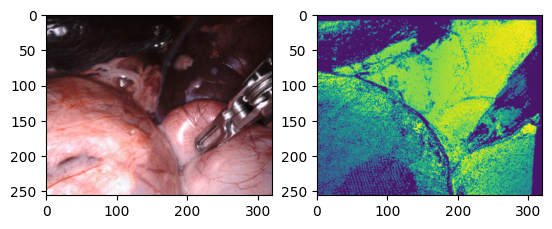

In [4]:
from glob import glob
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import tifffile
import cv2

class MyDataset(Dataset):
    def __init__(self, path_depth=None, transform=None):
        self.path_depth = path_depth
        self.transform = transform

    def __len__(self):
      return len(self.path_depth)

    def __getitem__(self, i):
        depth = tifffile.imread(self.path_depth[i])[:,:,2]
        depth = np.nan_to_num(depth, posinf=0, neginf=0)
        depth = cv2.applyColorMap(cv2.convertScaleAbs(depth, alpha=2.5), cv2.COLORMAP_JET)
        depth = Image.fromarray(depth).convert('L')
        path_ = self.path_depth[i]
        path_ = path_.replace('left', 'Left')
        path_ = path_.replace('right', 'Right')
        img = Image.open(path_[:-14] + 'Image.png').convert('RGB')
        if self.transform:
            img, depth = self.transform(img), self.transform(depth)
        return img, depth

transform_all = transforms.Compose([
    transforms.Resize((256, 320)),
    transforms.ToTensor(),
])

path_depth_all = glob('SCARED/*.tiff')
path_depth_train = path_depth_all[:56]
path_depth_valid = path_depth_all[56:]

dataset_train = MyDataset(path_depth=path_depth_train, transform=transform_all)
dataset_valid = MyDataset(path_depth=path_depth_train, transform=transform_all)
plt.subplot(121), plt.imshow(dataset_train[0][0].permute(1,2,0))
plt.subplot(122), plt.imshow(dataset_train[0][1][0])
print(dataset_train[0][0].shape, dataset_train[0][1][0].shape, dataset_train[0][1].min(), dataset_train[0][1].max())

train_loader = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=2)
valid_loader = DataLoader(dataset_valid, batch_size=128, shuffle=False, num_workers=2)

#Arguments

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import sys
import argparse
import numpy as np
import matplotlib.pyplot as plt

def seed_everything(seed=42):
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_args():
    parser = argparse.ArgumentParser(description='Kitti Interpolation Training')
    parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
    parser.add_argument('--batch_size', default=64, type=int, help='batch size')
    parser.add_argument('--valid_batch_size', default=128, type=int, help='batch size')
    parser.add_argument('--max_epochs', default=20, type=int, help='epoch number')
    parser.add_argument('--ckpt', type=str, default='best_model.pth.tar', help='total gpu')
    parser.add_argument('--criterion', type=str, default='bce', help='total gpu')

    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    return args

#Training

*abs error*: The difference between the predicted and the gt.             
*rel error*: The ratio of abs error and the actual gt.

mse = $\frac{1}{n}\sum_{i=1}^{n}(pred_i - gt_i)^2$

mae = $\frac{1}{n}\sum_{i=1}^{n}|pred_i - gt_i|$

**sq rel** =  $\frac{1}{n}\sum_{i=1}^{n}(pred_i - gt_i)^2/gt_i$

**abs rel** = $\frac{1}{n}\sum_{i=1}^{n}|pred_i - gt_i|/gt_i$

**rmse** = $\sqrt{\frac{1}{n}\sum_{i=1}^{n}(pred_i - gt_i)^2}$

**rmse log** = $\sqrt{\frac{1}{n}\sum_{i=1}^{n}(\log pred_i - \log gt_i)^2}$

In [ ]:
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics.functional import mean_absolute_error

import torchvision.transforms as transforms
from PIL import Image
import os


import math
import torch.nn.functional as F
import numpy as np
from torchmetrics import StructuralSimilarityIndexMeasure

device = 'cuda' if torch.cuda.is_available() else 'cpu'


class SSIM_Loss_Lib(nn.Module):
    def __init__(self, data_range=1):
        super().__init__()
        self.ssim = StructuralSimilarityIndexMeasure(data_range=data_range)

    def forward(self, img1, img2):
        return 1 - self.ssim(img1, img2)



def train(model, trainloader, optimizer, criterion):
    model.train()
    for i_batch, s_batch in enumerate(trainloader):
        image_batch, label_batch = s_batch[0].to(device), s_batch[1].to(device)
        outputs = model(image_batch)
        loss = criterion(outputs, label_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(model, testloader):
    model.eval()
    ssim = StructuralSimilarityIndexMeasure(data_range=1)
    mse_all = []
    ssim_all = []
    rmse_all = []
    rmselog_all = []
    mae_rel_all = []
    mse_rel_all = []
    with torch.no_grad():
        for i_batch, s_batch in enumerate(testloader):
            image_batch, label_batch = s_batch[0].to(device), s_batch[1].to(device)
            outputs = model(image_batch)
            outputs = nn.Sigmoid()(outputs)
            mse = nn.MSELoss()(outputs, label_batch)
            mse_all.append(mse.item())
            ssim_all.append(ssim(outputs.detach().cpu(), label_batch.detach().cpu()).item())
            rmse_all.append(math.sqrt(mse.item()))
            rmselog_all.append(math.sqrt(nn.MSELoss()(torch.log(outputs), torch.log(label_batch)).item()))
            mse_rel_all.append(mse.item() / label_batch[i_batch][0].detach().cpu().numpy())
            mae_rel_all.append(nn.L1Loss()(outputs, label_batch).item() / label_batch[i_batch][0].detach().cpu().numpy())
        return np.mean(mse_all), np.mean(ssim_all), np.mean(rmse_all), np.mean(rmselog_all), np.mean(mse_rel_all),  np.mean(mae_rel_all[0])


def main():
    seed_everything()
    args = get_args()

    path_depth_all = glob('SCARED/*.tiff')
    eighty_percent = math.ceil(len(path_depth_all)*0.8)
    path_depth_train = path_depth_all[:eighty_percent]
    path_depth_valid = path_depth_all[eighty_percent:]

    dataset_train = MyDataset(path_depth=path_depth_train, transform=transform_all)
    dataset_valid = MyDataset(path_depth=path_depth_valid, transform=transform_all)

    train_loader = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=2)
    valid_loader = DataLoader(dataset_valid, batch_size=128, shuffle=False, num_workers=2)

    print("Sample size- Train:%d, Valid: %d"%(len(dataset_train), len(dataset_valid)))
    #github: https://github.com/mateuszbuda/brain-segmentation-pytorch/blob/master/unet.py
    model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
            in_channels=3, out_channels=1, init_features=32, pretrained=False)
    model.to(device)

    args.criterion = 'bce'

    if args.criterion == 'mse':
        criterion = nn.MSELoss().to(device)
    elif args.criterion == 'l1':
        criterion = nn.L1Loss().to(device)
    elif args.criterion == 'ssim':
        criterion = SSIM_Loss_Lib(data_range=1.0).to(device)
    elif args.criterion == 'bce':
        criterion = nn.BCELoss().to(device)

    #optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=0.0001)
    optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    #criterion = nn.BCELoss().to(device)
    #best_mse, best_ssim, best_epoch = np.inf, np.inf, 0
    best_mse, best_ssim, best_rmse, best_rmselog, best_mse_rel, best_mae_rel, best_epoch = np.inf, np.inf, np.inf,np.inf,np.inf,np.inf,0
    for epoch_num in range(args.max_epochs):
        train(model, train_loader, optimizer, criterion)
        #mse, ssim = test(model, valid_loader)
        mse, ssim, rmse, rmselog, mse_rel, mae_rel = test(model, valid_loader)
        if mse < best_mse:
            best_mse = mse
            #best_ssim = ssim
            best_epoch = epoch_num
            torch.save(model.state_dict(), args.ckpt)
        if ssim < best_ssim:
            best_ssim = ssim
            best_epoch = epoch_num
        if rmse < best_rmse:
            best_rmse = rmse


        # print('Epoch:{}, Curr MSE(L2):{:.6f}, Curr SSIM:{:.6f}, Best MSE(L2):{:.6f}, Best SSIM:{:.6f}, Best Epoch:{}, Criterion:{}, Lr:{}'.
        #         format(epoch_num, mse, ssim, best_mse, best_ssim, best_epoch, args.criterion, optimizer.param_groups[0]['lr']))
        print('Epoch:{}, Curr MSE(L2):{:.6f}, RMSE:{:.6f}, RMSElog:{:.6f}, MSE rel:{:.6f}, MAE rel:{:.6f}, Best MSE(L2):{:.6f}, Best SSIM:{:.6f}, Best RMSE:{:.6f},Best Epoch:{}, Criterion:{}, Lr:{}'.
                format(epoch_num, mse, rmse, rmselog, mse_rel, mae_rel, best_mse, best_ssim, best_rmse, best_epoch, args.criterion, optimizer.param_groups[0]['lr']))

if __name__ == "__main__":
    main()

Sample size- Train:56, Valid: 14


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


Epoch:0, Curr MSE(L2):0.086329, RMSE:0.293818, RMSElog:0.901002, MSE rel:0.182709, MAE rel:0.496828, Best MSE(L2):0.086329, Best SSIM:0.368392, Best RMSE:0.293818,Best Epoch:0, Criterion:bce, Lr:0.0001
Epoch:1, Curr MSE(L2):0.086463, RMSE:0.294046, RMSElog:0.901392, MSE rel:0.182992, MAE rel:0.497046, Best MSE(L2):0.086329, Best SSIM:0.368362, Best RMSE:0.293818,Best Epoch:1, Criterion:bce, Lr:0.0001
Epoch:2, Curr MSE(L2):0.086584, RMSE:0.294252, RMSElog:0.901745, MSE rel:0.183249, MAE rel:0.497239, Best MSE(L2):0.086329, Best SSIM:0.368275, Best RMSE:0.293818,Best Epoch:2, Criterion:bce, Lr:0.0001
Epoch:3, Curr MSE(L2):0.086692, RMSE:0.294435, RMSElog:0.902056, MSE rel:0.183477, MAE rel:0.497411, Best MSE(L2):0.086329, Best SSIM:0.368231, Best RMSE:0.293818,Best Epoch:3, Criterion:bce, Lr:0.0001
Epoch:4, Curr MSE(L2):0.086782, RMSE:0.294587, RMSElog:0.902314, MSE rel:0.183667, MAE rel:0.497555, Best MSE(L2):0.086329, Best SSIM:0.368207, Best RMSE:0.293818,Best Epoch:4, Criterion:bce, 